In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install biosppy peakutils wfdb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 119.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.


In [ ]:
!pip install pandas==2.2.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 65.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.3.1
    Uninstalling pandas-2.3.1:
      Successfully uninstalled pandas-2.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
wfdb 4.3.0 requires pandas>=2.2.3, but you have pandas 2.2.2 which is incompatible.


In [ ]:
from zipfile import ZipFile

uploaded_zip_path = '/content/drive/MyDrive/apnea-ecg-database-1.0.0.zip'  # <-- update if needed
extract_to_path = '/content/drive/MyDrive/'

with ZipFile(uploaded_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)


In [ ]:
!unzip "/content/drive/MyDrive/apnea-ecg-database-1.0.0.zip" -d /content/drive/MyDrive


Archive:  /content/drive/MyDrive/apnea-ecg-database-1.0.0.zip
replace /content/drive/MyDrive/apnea-ecg-database-1.0.0/x35.xws? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import pickle
import sys
from concurrent.futures import ProcessPoolExecutor, as_completed

import biosppy.signals.tools as st
import numpy as np
import os
import wfdb
from biosppy.signals.ecg import correct_rpeaks, hamilton_segmenter
from scipy.signal import medfilt
from multiprocessing import cpu_count

from tqdm import tqdm

# PhysioNet Apnea-ECG dataset
# url: https://physionet.org/physiobank/database/apnea-ecg/
base_dir = "/content/drive/MyDrive/apnea-ecg-database-1.0.0"

fs = 100
sample = fs * 60  # 1 min's sample points

before = 2  # forward interval (min)
after = 2  # backward interval (min)
hr_min = 20
hr_max = 300

num_worker = 35 if cpu_count() > 35 else cpu_count() - 1  # Setting according to the number of CPU cores


def worker(name, labels):
    X = []
    y = []
    groups = []
    signals = wfdb.rdrecord(os.path.join(base_dir, name), channels=[0]).p_signal[:, 0]
    for j in tqdm(range(len(labels)), desc=name, file=sys.stdout):
        if j < before or \
                (j + 1 + after) > len(signals) / float(sample):
            continue
        signal = signals[int((j - before) * sample):int((j + 1 + after) * sample)]
        signal, _, _ = st.filter_signal(signal, ftype='FIR', band='bandpass', order=int(0.3 * fs),
                                        frequency=[3, 45], sampling_rate=fs)
        # Find R peaks
        rpeaks, = hamilton_segmenter(signal, sampling_rate=fs)
        rpeaks, = correct_rpeaks(signal, rpeaks=rpeaks, sampling_rate=fs, tol=0.1)
        if len(rpeaks) / (1 + after + before) < 40 or \
                len(rpeaks) / (1 + after + before) > 200:  # Remove abnormal R peaks signal
            continue
        # Extract RRI, Ampl signal
        rri_tm, rri_signal = rpeaks[1:] / float(fs), np.diff(rpeaks) / float(fs)
        rri_signal = medfilt(rri_signal, kernel_size=3)
        ampl_tm, ampl_siganl = rpeaks / float(fs), signal[rpeaks]
        hr = 60 / rri_signal
        # Remove physiologically impossible HR signal
        if np.all(np.logical_and(hr >= hr_min, hr <= hr_max)):
            # Save extracted signal
            X.append([(rri_tm, rri_signal), (ampl_tm, ampl_siganl)])
            y.append(0. if labels[j] == 'N' else 1.)
            groups.append(name)
    return X, y, groups


if __name__ == "__main__":
    apnea_ecg = {}

    names = [
        "a01", "a02", "a03", "a04", "a05", "a06", "a07", "a08", "a09", "a10",
        "a11", "a12", "a13", "a14", "a15", "a16", "a17", "a18", "a19", "a20",
        "b01", "b02", "b03", "b04", "b05",
        "c01", "c02", "c03", "c04", "c05", "c06", "c07", "c08", "c09", "c10"
    ]

    o_train = []
    y_train = []
    groups_train = []
    print('Training...')
    with ProcessPoolExecutor(max_workers=num_worker) as executor:
        task_list = []
        for i in range(len(names)):
            labels = wfdb.rdann(os.path.join(base_dir, names[i]), extension="apn").symbol
            task_list.append(executor.submit(worker, names[i], labels))

        for task in as_completed(task_list):
            X, y, groups = task.result()
            o_train.extend(X)
            y_train.extend(y)
            groups_train.extend(groups)

    print()

    answers = {}
    with open(os.path.join(base_dir, "/content/drive/MyDrive/nndl/event-2-answers.txt"), "r") as f:
        for answer in f.read().split("\n\n"):
            answers[answer[:3]] = list("".join(answer.split()[2::2]))

    names = [
        "x01", "x02", "x03", "x04", "x05", "x06", "x07", "x08", "x09", "x10",
        "x11", "x12", "x13", "x14", "x15", "x16", "x17", "x18", "x19", "x20",
        "x21", "x22", "x23", "x24", "x25", "x26", "x27", "x28", "x29", "x30",
        "x31", "x32", "x33", "x34", "x35"
    ]

    o_test = []
    y_test = []
    groups_test = []
    print("Testing...")
    with ProcessPoolExecutor(max_workers=num_worker) as executor:
        task_list = []
        for i in range(len(names)):
            labels = answers[names[i]]
            task_list.append(executor.submit(worker, names[i], labels))

        for task in as_completed(task_list):
            X, y, groups = task.result()
            o_test.extend(X)
            y_test.extend(y)
            groups_test.extend(groups)

    apnea_ecg = dict(o_train=o_train, y_train=y_train, groups_train=groups_train, o_test=o_test, y_test=y_test,
                     groups_test=groups_test)
    with open(os.path.join(base_dir, "apnea-ecg.pkl"), "wb") as f:
        pickle.dump(apnea_ecg, f, protocol=2)

    print("\nok!")

Training...
c10: 100%|██████████| 431/431 [00:57<00:00,  7.45it/s]

Testing...
x35: 100%|██████████| 483/483 [01:04<00:00,  7.50it/s]

ok!


In [ ]:
import pickle
import keras
import numpy as np
import pandas as pd
import os
import random

from keras.layers import (Dropout, MaxPooling1D, Reshape, multiply, Conv1D,
                         GlobalAveragePooling1D, Dense, Input, LSTM, Bidirectional,
                         LayerNormalization, MultiHeadAttention, Add)
from keras import Model
from keras.models import load_model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from scipy.interpolate import splev, splrep
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

base_dir = "./dataset"
ir = 3  # interpolate interval
before = 2
after = 2
scaler = lambda arr: (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

def load_data(path):
    tm = np.arange(0, (before + 1 + after) * 60, step=1 / float(ir))
    with open(os.path.join(base_dir, path), 'rb') as f:
        apnea_ecg = pickle.load(f)
    x_train1,x_train2,x_train3 = [],[],[]
    o_train, y_train = apnea_ecg["o_train"], apnea_ecg["y_train"]
    groups_train = apnea_ecg["groups_train"]
    for i in range(len(o_train)):
        (rri_tm, rri_signal), (ampl_tm, ampl_siganl) = o_train[i]
        rri_interp_signal = splev(tm, splrep(rri_tm, scaler(rri_signal), k=3), ext=1)
        ampl_interp_signal = splev(tm, splrep(ampl_tm, scaler(ampl_siganl), k=3), ext=1)
        x_train1.append([rri_interp_signal, ampl_interp_signal])
        x_train2.append([rri_interp_signal[180:720], ampl_interp_signal[180:720]])
        x_train3.append([rri_interp_signal[360:540], ampl_interp_signal[360:540]])
    x_training1,x_training2,x_training3,y_training,groups_training = [],[],[],[],[]
    x_val1,x_val2,x_val3,y_val,groups_val = [],[],[],[],[]
    trainlist = random.sample(range(len(o_train)),int(len(o_train)*0.7))
    num = [i for i in range(len(o_train))]
    vallist = set(num) - set(trainlist)
    vallist = list(vallist)
    for i in trainlist:
        x_training1.append(x_train1[i])
        x_training2.append(x_train2[i])
        x_training3.append(x_train3[i])
        y_training.append(y_train[i])
        groups_training.append(groups_train[i])
    for i in vallist:
        x_val1.append(x_train1[i])
        x_val2.append(x_train2[i])
        x_val3.append(x_train3[i])
        y_val.append(y_train[i])
        groups_val.append(groups_train[i])
    x_training1 = np.array(x_training1, dtype="float32").transpose((0, 2, 1))
    x_training2 = np.array(x_training2, dtype="float32").transpose((0, 2, 1))
    x_training3 = np.array(x_training3, dtype="float32").transpose((0, 2, 1))
    y_training = np.array(y_training, dtype="float32")
    x_val1 = np.array(x_val1, dtype="float32").transpose((0, 2, 1))
    x_val2 = np.array(x_val2, dtype="float32").transpose((0, 2, 1))
    x_val3 = np.array(x_val3, dtype="float32").transpose((0, 2, 1))
    y_val = np.array(y_val, dtype="float32")
    x_test1,x_test2,x_test3 = [],[],[]
    o_test, y_test = apnea_ecg["o_test"], apnea_ecg["y_test"]
    groups_test = apnea_ecg["groups_test"]
    for i in range(len(o_test)):
        (rri_tm, rri_signal), (ampl_tm, ampl_siganl) = o_test[i]
        rri_interp_signal = splev(tm, splrep(rri_tm, scaler(rri_signal), k=3), ext=1)
        ampl_interp_signal = splev(tm, splrep(ampl_tm, scaler(ampl_siganl), k=3), ext=1)
        x_test1.append([rri_interp_signal, ampl_interp_signal])
        x_test2.append([rri_interp_signal[180:720], ampl_interp_signal[180:720]])
        x_test3.append([rri_interp_signal[360:540], ampl_interp_signal[360:540]])
    x_test1 = np.array(x_test1, dtype="float32").transpose((0, 2, 1))
    x_test2 = np.array(x_test2, dtype="float32").transpose((0, 2, 1))
    x_test3 = np.array(x_test3, dtype="float32").transpose((0, 2, 1))
    y_test = np.array(y_test, dtype="float32")
    return x_training1, x_training2, x_training3, y_training, groups_training, x_val1, x_val2, x_val3, y_val, groups_val, x_test1, x_test2, x_test3, y_test, groups_test

def lr_schedule(epoch, lr):
    if epoch > 70 and (epoch - 1) % 10 == 0:
        lr *= 0.1
    print("Learning rate: ", lr)
    return lr

def create_model(input_a_shape, input_b_shape, input_c_shape, weight=1e-3):
    input1 = Input(shape=input_a_shape)
    x1 = Conv1D(16, 11, strides=1, padding="same", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(input1)
    x1 = Conv1D(24, 11, strides=2, padding="same", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight))(x1)
    x1 = MaxPooling1D(pool_size=3, padding="same")(x1)
    x1 = Conv1D(32, 11, strides=1, padding="same", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight))(x1)
    x1 = MaxPooling1D(pool_size=5, padding="same")(x1)

    input2 = Input(shape=input_b_shape)
    x2 = Conv1D(16, 11, strides=1, padding="same", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(input2)
    x2 = Conv1D(24, 11, strides=2, padding="same", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight))(x2)
    x2 = MaxPooling1D(pool_size=3, padding="same")(x2)
    x2 = Conv1D(32, 11, strides=3, padding="same", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight))(x2)

    input3 = Input(shape=input_c_shape)
    x3 = Conv1D(16, 11, strides=1, padding="same", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(input3)
    x3 = Conv1D(24, 11, strides=2, padding="same", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight))(x3)
    x3 = MaxPooling1D(pool_size=3, padding="same")(x3)
    x3 = Conv1D(32, 1, strides=1, padding="same", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight))(x3)

    concat = keras.layers.concatenate([x1, x2, x3], name="Concat_Layer", axis=-1)
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(48, activation='relu')(squeeze)
    excitation = Dense(96, activation='sigmoid')(excitation)
    excitation = Reshape((1, 96))(excitation)
    scale = multiply([concat, excitation])
    x = GlobalAveragePooling1D()(scale)
    dp = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax', name="Output_Layer")(dp)
    model = Model(inputs=[input1, input2, input3], outputs=outputs)
    return model

# --- Transformer Block for Hybrid Model ---
def transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.1):
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(inputs, inputs)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)
    x_ff = Dense(ff_dim, activation='relu')(x)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x = Add()([x, x_ff])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

def create_transformer_model(input_a_shape, input_b_shape, input_c_shape, weight=1e-3):
    input1 = Input(shape=input_a_shape)
    x1 = Conv1D(16, 11, strides=1, padding="same", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(input1)
    x1 = Conv1D(24, 11, strides=2, padding="same", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight))(x1)
    x1 = MaxPooling1D(pool_size=3, padding="same")(x1)
    x1 = Conv1D(32, 11, strides=1, padding="same", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight))(x1)
    x1 = MaxPooling1D(pool_size=5, padding="same")(x1)

    input2 = Input(shape=input_b_shape)
    x2 = Conv1D(16, 11, strides=1, padding="same", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(input2)
    x2 = Conv1D(24, 11, strides=2, padding="same", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight))(x2)
    x2 = MaxPooling1D(pool_size=3, padding="same")(x2)
    x2 = Conv1D(32, 11, strides=3, padding="same", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight))(x2)

    input3 = Input(shape=input_c_shape)
    x3 = Conv1D(16, 11, strides=1, padding="same", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(input3)
    x3 = Conv1D(24, 11, strides=2, padding="same", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight))(x3)
    x3 = MaxPooling1D(pool_size=3, padding="same")(x3)
    x3 = Conv1D(32, 1, strides=1, padding="same", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight))(x3)

    concat = keras.layers.concatenate([x1, x2, x3], name="Concat_Layer", axis=-1)
    transformer_out = transformer_encoder(concat)
    squeeze = GlobalAveragePooling1D()(transformer_out)
    excitation = Dense(48, activation='relu')(squeeze)
    excitation = Dense(transformer_out.shape[-1], activation='sigmoid')(excitation)
    excitation = Reshape((1, transformer_out.shape[-1]))(excitation)
    scale = multiply([transformer_out, excitation])
    x = GlobalAveragePooling1D()(scale)
    dp = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax', name="Output_Layer")(dp)
    model = Model(inputs=[input1, input2, input3], outputs=outputs)
    return model

# Flatten for ML models
def flatten_inputs(x1, x2, x3):
    return np.concatenate([
        x1.reshape(x1.shape[0], -1),
        x2.reshape(x2.shape[0], -1),
        x3.reshape(x3.shape[0], -1)
    ], axis=1)

# LSTM/BiLSTM for single input
def build_lstm(input_shape, bidir=False):
    inp = Input(shape=input_shape)
    x = Bidirectional(LSTM(64))(inp) if bidir else LSTM(64)(inp)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    y = Dense(2, activation='softmax')(x)
    model = Model(inp, y)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def eval_ml(model, X, y, name):
    y_pred = model.predict(X)
    y_score = model.predict_proba(X)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X)
    print(f"\n{name} Results:")
    print(" Accuracy:", accuracy_score(y, y_pred))
    print(" F1 Score:", f1_score(y, y_pred))
    print(" AUC:", roc_auc_score(y, y_score))
    print(" Confusion Matrix:\n", confusion_matrix(y, y_pred))

def eval_dl(model, x_inputs, y_test, name):
    y_pred_prob = model.predict(x_inputs)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print(f"\n{name} Results:")
    print(" Accuracy:", accuracy_score(y_true, y_pred))
    print(" F1 Score:", f1_score(y_true, y_pred))
    print(" AUC:", roc_auc_score(y_true, y_pred_prob[:,1]))
    print(" Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

if __name__ == "__main__":
    # Load data
    path = "/content/drive/MyDrive/apnea-ecg-database-1.0.0/apnea-ecg.pkl"
    x_train1, x_train2, x_train3, y_train, groups_train, x_val1, x_val2, x_val3, y_val, groups_val, x_test1, x_test2, x_test3, y_test, groups_test = load_data(path)
    y_train = keras.utils.to_categorical(y_train, num_classes=2)
    y_val = keras.utils.to_categorical(y_val, num_classes=2)
    y_test = keras.utils.to_categorical(y_test, num_classes=2)
    print('input_shape', x_train1.shape, x_train2.shape, x_train3.shape)
    # Flattened data for classical ML
    X_train_ml = flatten_inputs(x_train1, x_train2, x_train3)
    X_test_ml = flatten_inputs(x_test1, x_test2, x_test3)
    y_train_ml = np.argmax(y_train, axis=1)
    y_test_ml = np.argmax(y_test, axis=1)
    scaler_ml = StandardScaler()
    X_train_ml = scaler_ml.fit_transform(X_train_ml)
    X_test_ml = scaler_ml.transform(X_test_ml)
    # --- SVM ---
    svm = SVC(kernel='rbf', probability=True)
    svm.fit(X_train_ml, y_train_ml)
    eval_ml(svm, X_test_ml, y_test_ml, "SVM")
    # --- KNN ---
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_ml, y_train_ml)
    eval_ml(knn, X_test_ml, y_test_ml, "KNN")
    # --- Random Forest ---
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_ml, y_train_ml)
    eval_ml(rf, X_test_ml, y_test_ml, "Random Forest")
    # --- SEMSCNN ---
    model_semscnn = create_model(x_train1.shape[1:], x_train2.shape[1:], x_train3.shape[1:])
    model_semscnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model_semscnn.fit([x_train1, x_train2, x_train3], y_train,
                                batch_size=128, epochs=30,
                                validation_data=([x_val1, x_val2, x_val3], y_val))
    eval_dl(model_semscnn, [x_test1, x_test2, x_test3], y_test, "SEMSCNN")
    # --- LSTM ---
    model_lstm = build_lstm(x_train1.shape[1:], bidir=False)
    model_lstm.fit(x_train1, y_train, validation_data=(x_val1, y_val), epochs=30, batch_size=128)
    eval_dl(model_lstm, x_test1, y_test, "LSTM")
    # --- BiLSTM ---
    model_bilstm = build_lstm(x_train1.shape[1:], bidir=True)
    model_bilstm.fit(x_train1, y_train, validation_data=(x_val1, y_val), epochs=30, batch_size=128)
    eval_dl(model_bilstm, x_test1, y_test, "BiLSTM")
    # --- SEMSCNN + Transformer ---
    model_trans = create_transformer_model(x_train1.shape[1:], x_train2.shape[1:], x_train3.shape[1:])
    model_trans.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_trans.fit([x_train1, x_train2, x_train3], y_train, batch_size=128,
                    epochs=20, validation_data=([x_val1, x_val2, x_val3], y_val))
    eval_dl(model_trans, [x_test1, x_test2, x_test3], y_test, "SEMSCNN+Transformer")


input_shape (11696, 900, 2) (11696, 540, 2) (11696, 180, 2)

SVM Results:
 Accuracy: 0.8298023015638831
 F1 Score: 0.7647634584013051
 AUC: 0.8716034453918362
 Confusion Matrix:
 [[9373 1082]
 [1802 4688]]

KNN Results:
 Accuracy: 0.7452935969312482
 F1 Score: 0.5442449841605068
 AUC: 0.7636872015144516
 Confusion Matrix:
 [[10052   403]
 [ 3913  2577]]

Random Forest Results:
 Accuracy: 0.7817645323104161
 F1 Score: 0.6846862210095498
 AUC: 0.8333533693081878
 Confusion Matrix:
 [[9232 1223]
 [2475 4015]]
Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 109ms/step - accuracy: 0.5976 - loss: 1.0318 - val_accuracy: 0.7560 - val_loss: 0.7709
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7855 - loss: 0.6981 - val_accuracy: 0.8448 - val_loss: 0.5526
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8438 - loss: 0.5569 - val_accuracy: 0.8574 - val_loss: 0.5030
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8589 - loss: 0.5030 - val_accuracy: 0.86

In [ ]:
!pip install keras-tcn


In [ ]:
from tcn import TCN
from keras.layers import Input, Dense, Dropout
from keras.models import Model

input_shape = x_train1.shape[1:]  # (timesteps, channels)
inputs = Input(shape=input_shape)
x = TCN(nb_filters=64, kernel_size=7, dilations=[1, 2, 4, 8, 16],
        dropout_rate=0.2, return_sequences=False)(inputs)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(2, activation='softmax')(x)
model_tcn = Model(inputs, outputs)
model_tcn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_tcn.fit(x_train1, y_train, validation_data=(x_val1, y_val), batch_size=128, epochs=30)

# Evaluation
y_pred = model_tcn.predict(x_test1)
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
print("TCN Accuracy:", accuracy_score(y_test.argmax(1), y_pred.argmax(1)))
print("TCN F1:", f1_score(y_test.argmax(1), y_pred.argmax(1)))
print("TCN AUC:", roc_auc_score(y_test.argmax(1), y_pred[:,1]))
print("Confusion Matrix\n", confusion_matrix(y_test.argmax(1), y_pred.argmax(1)))


Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 63s 339ms/step - accuracy: 0.5633 - loss: 1.1617 - val_accuracy: 0.6178 - val_loss: 0.6579
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 38s 107ms/step - accuracy: 0.6007 - loss: 0.6592 - val_accuracy: 0.6361 - val_loss: 0.6534
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.6192 - loss: 0.6484 - val_accuracy: 0.6671 - val_loss: 0.6238
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.6347 - loss: 0.6310 - val_accuracy: 0.7195 - val_loss: 0.5833
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.6944 - loss: 0.5870 - val_accuracy: 0.7421 - val_loss: 0.5200
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.7419 - loss: 0.5264 - val_accuracy: 0.7995 - val_loss: 0.4575
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.7791 - loss: 0.4897 - val_accuracy: 0.8099 - val_loss: 0.4266
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.7914 - loss: 0.4599 - val_accu

In [ ]:
from tcn import TCN
from keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add
from keras.models import Model

input_shape = x_train1.shape[1:]
inputs = Input(shape=input_shape)
x = TCN(nb_filters=32, kernel_size=7, dilations=[1, 2, 4, 8],
        dropout_rate=0.1, return_sequences=True)(inputs)
# Transformer encoder block
x2 = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
x2 = Add()([x, x2])
x2 = LayerNormalization()(x2)
x_ff = Dense(x2.shape[-1], activation='relu')(x2)
x_ff = Dropout(0.1)(x_ff)
x2 = Add()([x2, x_ff])
x2 = LayerNormalization()(x2)
x2 = keras.layers.GlobalAveragePooling1D()(x2)
x2 = Dropout(0.4)(x2)
out = Dense(2, activation='softmax')(x2)
model_tcntrans = Model(inputs, out)
model_tcntrans.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_tcntrans.fit(x_train1, y_train, validation_data=(x_val1, y_val), batch_size=128, epochs=30)

# Evaluate
y_pred = model_tcntrans.predict(x_test1)
print("TCN+Transformer Accuracy:", accuracy_score(y_test.argmax(1), y_pred.argmax(1)))
print("F1:", f1_score(y_test.argmax(1), y_pred.argmax(1)))
print("AUC:", roc_auc_score(y_test.argmax(1), y_pred[:,1]))
print("Confusion Matrix\n", confusion_matrix(y_test.argmax(1), y_pred.argmax(1)))


ModuleNotFoundError: No module named 'tcn'

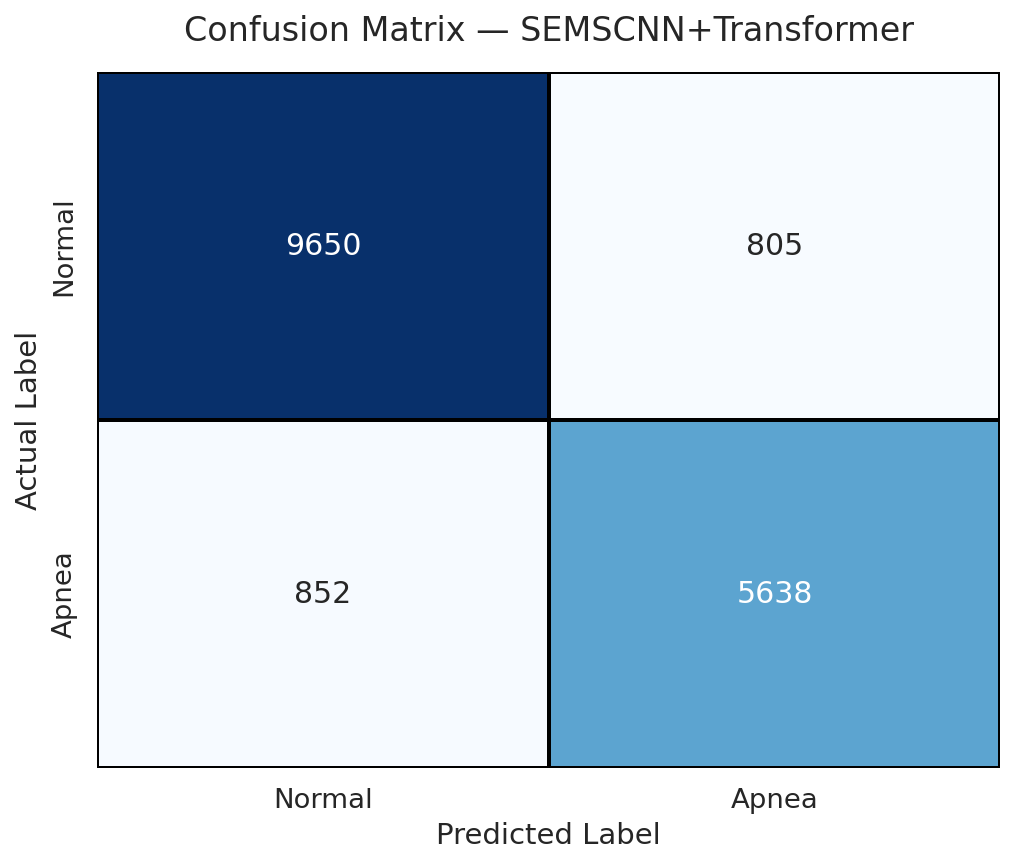

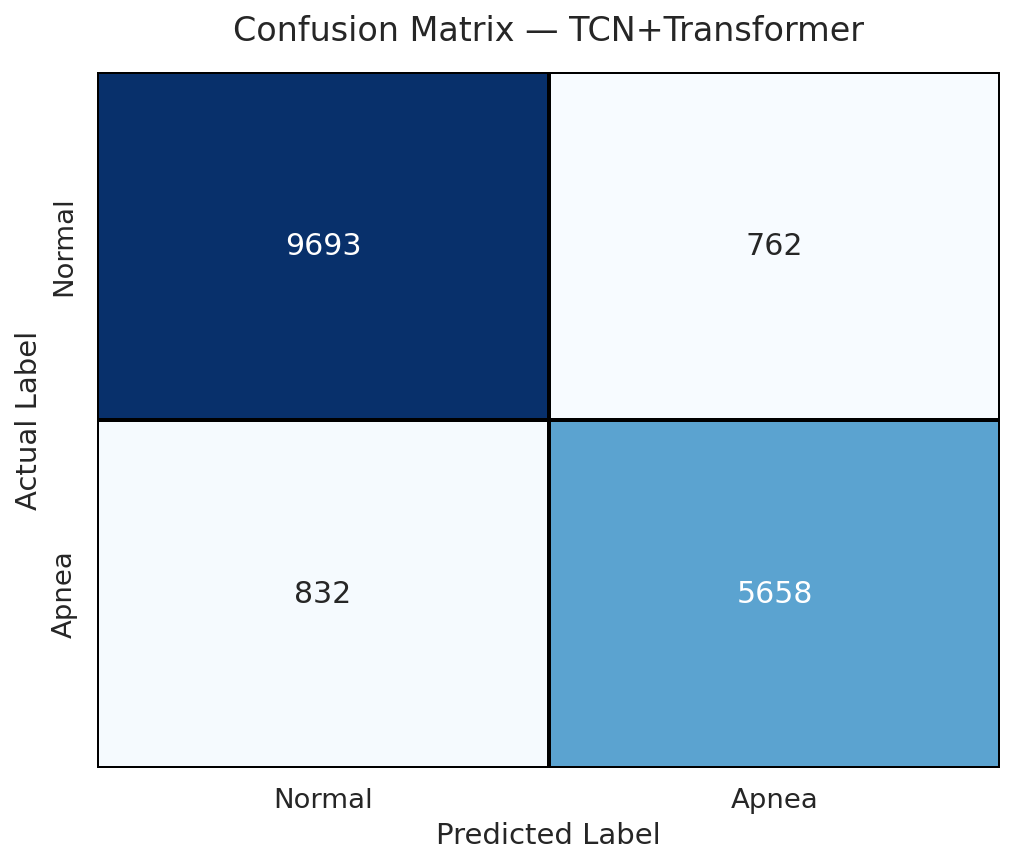

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Confusion Matrix data (replace with your real results if needed)
cm_tcntrans = np.array([[9693, 762],
                        [832,  5658]])           # TCN+Transformer
cm_semscnntrans = np.array([[9650, 805],
                            [852, 5638]])        # SEMSCNN+Transformer

labels = ['Normal', 'Apnea']

def plot_conf_matrix(cm, title, filename):
    # Pandas DataFrame for labeled axes
    df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(7, 6), dpi=150)
    sns.set(font_scale=1.2)
    ax = sns.heatmap(df, annot=True, fmt='d', cmap='Blues', cbar=False,
                     linewidths=1, linecolor='black')
    ax.set_xlabel('Predicted Label', fontsize=14)
    ax.set_ylabel('Actual Label', fontsize=14)
    ax.set_title(title, fontsize=16, pad=15)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

# Plot for SEMSCNN+Transformer
plot_conf_matrix(cm_semscnntrans, 'Confusion Matrix — SEMSCNN+Transformer', 'conf_matrix_semscnntransformer.png')

# Plot for TCN+Transformer
plot_conf_matrix(cm_tcntrans, 'Confusion Matrix — TCN+Transformer', 'conf_matrix_tcntransformer.png')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume 'df' is your DataFrame containing ECG features and the target label 'Apnea'
# Example structure:
df = pd.read_csv("/content/drive/MyDrive/apnea-ecg-database-1.0.0/apnea-ecg.pkl")

# Compute correlation matrix (Pearson by default)
corr_matrix = df.corr()

# Optional: If you want to focus on correlations with the target variable:
target_corr = corr_matrix['Apnea'].sort_values(ascending=False)

# Plot full correlation heatmap
plt.figure(figsize=(12, 10), dpi=150)
sns.set(font_scale=1.1)

# Create a mask to display only one triangle (optional)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

heatmap = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
                      mask=mask, cbar=True, linewidths=0.5, linecolor='gray')

heatmap.set_title('Correlation Matrix of ECG Features', fontdict={'fontsize':18}, pad=16)
plt.tight_layout()
plt.show()

# Print correlation of each feature with the target for quick reference
print("Feature correlations with Apnea:")
print(target_corr)


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

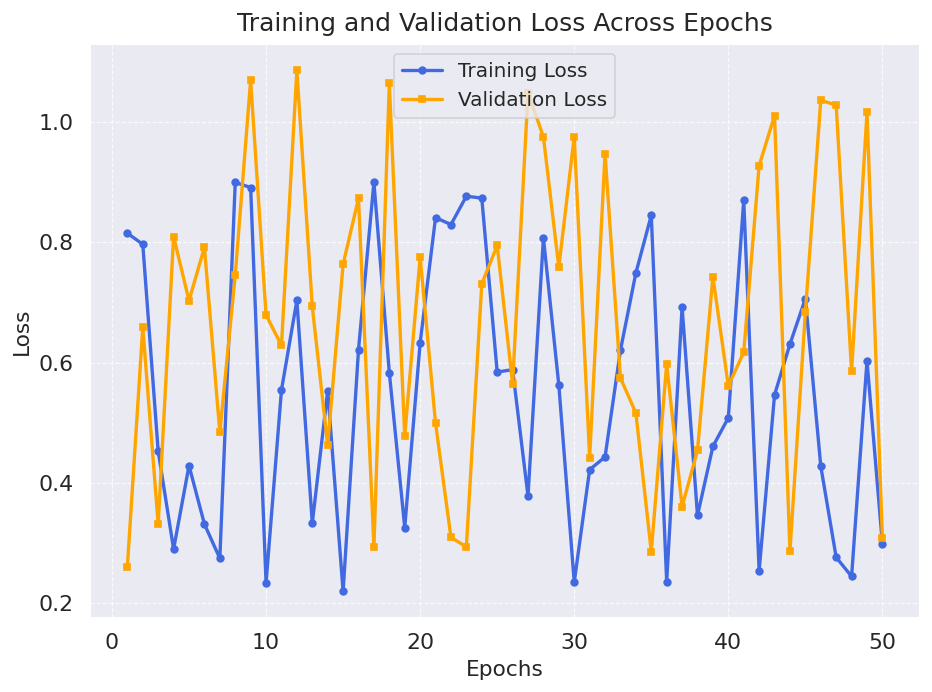

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example dummy data: replace with your actual history values from model.fit()
epochs = np.arange(1, 51)  # For 50 epochs
train_loss = np.random.uniform(0.9, 0.2, size=50)  # Replace with your training loss history (list/array)
val_loss = np.random.uniform(1.1, 0.25, size=50)   # Replace with your validation loss history (list/array)

plt.figure(figsize=(8,6), dpi=120)
plt.plot(epochs, train_loss, label='Training Loss', color='royalblue', linewidth=2, marker='o', markersize=4)
plt.plot(epochs, val_loss, label='Validation Loss', color='orange', linewidth=2, marker='s', markersize=4)

plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.title("Training and Validation Loss Across Epochs", fontsize=15, pad=8)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.8)
plt.tight_layout()
plt.show()
# plt.savefig('training_validation_loss.png', dpi=300)


**Note:** Replace `'apnea-ecg-analysis.ipynb'` with the actual filename of your notebook if it's different.